In [6]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch

In [7]:
# Order and names in the pseudocode
# x=(22.5,0) y=(0,-45) z=(0,0) a=(45,0)
# Channels: 1 2 3 4 13 14 23 24

## Matching the datafile name with the respective input and measurement basis
MBasisList=['x','y','z'] #in order: D L H

BasesO=['DD','DL','DH','LD','LL','LH', 'HD','HL', 'HH']

In [8]:
def FindingFile(containing, filenames):
    for file in filenames:
         if fnmatch.fnmatch(file, 'Bigiteration_0_'+containing+'_*'):
            return file
    print('No file containing: Bigiteration_0_', containing, '...')
    pass

In [9]:
### Getting the number of necessary files
n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        n_files+=1
        print

In [12]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)

mbasis_number=6

qubit_number=2
numberofchannels=8

dirinv=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype=complex)

Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

tomo_n=0
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    #filenames_aux=filenames_aux[1:]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        print(index, filenames_aux_second)
        os.chdir(working_dir+'\\'+filename+'\\'+filenames_aux_second+'\\'+'StateTomo')
        datafiles=[i for i in glob.glob("*")]
        
        counts=np.zeros((numberofchannels,3**qubit_number), dtype=int)
        counts_aux=np.zeros((2**qubit_number,3**qubit_number), dtype=float)
        heralding_single=np.zeros((3**qubit_number), dtype=int)
        xp_counts=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
        efficiencies=np.zeros(8, dtype=float)
        expectations=np.zeros(3, dtype=float)

        ##################### STATE TOMOGRAPHY ##############################

        ##Calculating the efficiencies of each detector
        eff=np.array(['zz', 'za', 'az', 'aa'])
        for w in range(4):
            file=FindingFile(eff[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    for iter in range (len(fields)-7):
                        efficiencies[iter]+=float(fields[iter])
            #print('Base, counts', w, fields)


        ### Simulated counts using Simon's tomography functions
        # data is saved as "Bigiteration_0_xy" with x(y) being the measurement(input) basis
        # H is channels 2 and 3
        bases=np.array(['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])#, ## order: D, L, H



        ### Opening the data files and writing the data in counts_aux array
        for w in range(3**qubit_number):
            file=FindingFile(bases[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    for iter in range (len(fields)-7):
                        # In counts[a][b][c][d], 'a' corresponds to the channel (in order): 1 2 3 4 13 14 23 24 (defined in pseudo)
                        counts[iter][w]=fields[iter]

            counts_aux[0][w]=counts[-2][w]
            counts_aux[1][w]=counts[-1][w]
            counts_aux[2][w]=counts[-4][w]
            counts_aux[3][w]=counts[-3][w]
            #heralding_single[w]=counts[3][w]

        ### Normalizing the counts with the detectors efficiencies
        efficiencies=efficiencies/np.max(efficiencies)
        aux=0
        for w in range(3**qubit_number):
           #heralding_single[w]=heralding_single[w]/efficiencies[3]
            counts_aux[0][w]=counts_aux[0][w]/float(efficiencies[-2])#*heralding_single[w]*1e-6)
            counts_aux[1][w]=counts_aux[1][w]/float(efficiencies[-1])#*heralding_single[w]*1e-6)
            counts_aux[2][w]=counts_aux[2][w]/float(efficiencies[-4])#*heralding_single[w]*1e-6)
            counts_aux[3][w]=counts_aux[3][w]/float(efficiencies[-3])#*heralding_single[w]*1e-6)

            #if w==0: ## XX expectation value
            #    expectations[0]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==4: ## YY expectation value
            #    expectations[1]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==8: ## ZZ expectation value
            #    expectations[2]=(counts_aux[1][w]+counts_aux[2][w]-counts_aux[0][w]-counts_aux[3][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        if (aux<(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])):
                aux=(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        ### Sanity check: This prints the normalized number of counts for each measurement basis
        # The total number of counts (considering all output ports of the PBS's) should remain constant (we should see 1 for all of them)
        for w in range(3**qubit_number):
            print('Output basis: ', BasesO[w], '; Sum of counts normalized: ', (counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])/aux)

        xp_counts[:][:]=np.array(np.transpose(counts_aux[:][:])) # get the experimental counts

        statetomo=LRETomography(int(qubit_number), xp_counts[:][:], 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
        statetomo.run() ### Runs fast maximum likelihood estimation
        statetomo.quantum_state.get_density_matrix()
        dirinv[tomo_n]=statetomo.quantum_state.get_density_matrix()
        print('\n Fast maximum likelihood estimation: \n', dirinv[tomo_n], '\n')
        tomo_n+=1

0 StateTomography202205241431
Output basis:  DD ; Sum of counts normalized:  1.000225525895713
Output basis:  DL ; Sum of counts normalized:  0.9943713298289455
Output basis:  DH ; Sum of counts normalized:  0.9953498576514758
Output basis:  LD ; Sum of counts normalized:  0.9929429746608089
Output basis:  LL ; Sum of counts normalized:  0.994653846089413
Output basis:  LH ; Sum of counts normalized:  0.9934731203348942
Output basis:  HD ; Sum of counts normalized:  0.9944309501345517
Output basis:  HL ; Sum of counts normalized:  0.9943752810798586
Output basis:  HH ; Sum of counts normalized:  1.0


TypeError: __init__() missing 1 required positional argument: 'working_dir'

In [48]:
### Fidelity with expectation values
print("Fidelity is: ", (1+np.sum(np.abs(expectations)))/4)

Fidelity is:  0.25


In [49]:
### Functions that will be necessary
def fidelity(ideal, real):
    return (ideal@real@np.transpose(np.conjugate(ideal)))

def GeneralUnitary(x):
    return np.array([[np.exp(1j*x[0])*np.cos(x[2]), np.exp(1j*x[1])*np.sin(x[2])],[-np.exp(-1j*x[1])*np.sin(x[2]), np.exp(-1j*x[0])*np.cos(x[2])]])

def ApplyUnitaryToDM(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

def fUnitary(x, *args):
    U1=GeneralUnitary(x[:3])
    U2=GeneralUnitary(x[3:])
    return -np.abs(fidelity(bell, ApplyUnitaryToDM(np.kron(U1,U2), dirinv[index])))

### Jones formalism representation of a waveplate as a funtion of:
### angle of the WP to the horizontal (t) and the phase difference induced between V and H (n)
def WP_rotation(t, n):
    R= np.exp(-1j*n/2)*np.array([[np.cos(t)**2+np.exp(1j*n)*np.sin(t)**2,(1-np.exp(1j*n))*np.cos(t)*np.sin(t)],
                [(1-np.exp(1j*n))*np.cos(t)*np.sin(t),np.sin(t)**2+np.exp(1j*n)*np.cos(t)**2]])
    return(R)

In [50]:
### Fidelity as a projection

bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

for i in range(n_files):
    print(fidelity(bell, dirinv[i]))

(0.0017915943895243848+0j)
(0.003059174436725265+2.168404344971009e-19j)
(0.15851175287371694+5.551115123125783e-17j)
(0.002526036346619967+6.505213034913027e-19j)
(0.8466010653572945+1.1102230246251565e-16j)
(0.0034729433787091387+3.469446951953614e-18j)
(0.0009521097978596898+3.7947076036992655e-19j)
(0.9008794077601421+4.163336342344337e-17j)
(0.00048206253848216484+3.2526065174565133e-19j)
(0.003075750441623664+1.0842021724855044e-18j)
(0.0019132385662642213-3.2526065174565133e-19j)
(0.9897118630203339+6.938893903907228e-18j)
(0.9770677758079302+2.0816681711721685e-17j)
(0.003050776618553331+0j)
(0.9284441877079542+0j)
(0.0037072327417679843+1.951563910473908e-18j)
(0.003075750441623664+1.0842021724855044e-18j)
(0.836307286547713+5.551115123125783e-17j)
(0.7206937890949165-1.1102230246251565e-16j)
(0.0033593260084710777+1.5178830414797062e-18j)
(0.5597597613202936+8.326672684688674e-17j)
(0.0028495960389883545+1.3010426069826053e-18j)
(0.0023534840684726523+4.336808689942018e-19j)


In [51]:
### Optimization of a unitary up to isometry
fid=np.zeros((n_files))
Optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number))
for index in range(n_files):
    result_w=diffev2(fUnitary, x0=np.array([0, 0.4, 0, 0, 0.3, 1.5]), args=dirinv[index], strategy=Best1Bin, bounds=[(-np.pi,np.pi)]*6, npop=50, gtol=100, disp=True, ftol=1e-20, itermon=VerboseMonitor(50), handler=False)
    print('\n The parameters are: ', index, result_w)

    print('\n with a fidelity of: ', -fUnitary(result_w, bellmatrix))

    Unit1=GeneralUnitary(result_w[:3])
    Unit2=GeneralUnitary(result_w[3:])
    print('Unitaries: \n U1=', Unit1, '\n U2=', Unit2)
    Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])
    print('\n State after unitaries: \n', Optimized_matrix[index])
    fid[index]=fidelity(bell, Optimized_matrix[index])
    print("\n\n Fidelity is: ", fidelity(bell, Optimized_matrix[index]))

Generation 0 has ChiSquare: -0.934904
Generation 50 has ChiSquare: -0.993267
Generation 100 has ChiSquare: -0.993267
Generation 150 has ChiSquare: -0.993267
Generation 200 has ChiSquare: -0.993267
Generation 250 has ChiSquare: -0.993267
Generation 300 has ChiSquare: -0.993267
Generation 350 has ChiSquare: -0.993267
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.993267
         Iterations: 369
         Function evaluations: 18500

 The parameters are:  0 [-6.74660327e-02 -2.77392698e-01 -8.83653846e-04  6.79264513e-01
  7.09381532e-02  1.57318146e+00]

 with a fidelity of:  0.9932672540136827
Unitaries: 
 U1= [[ 9.97724641e-01-0.06741484j -8.49874046e-04+0.00024199j]
 [ 8.49874046e-04+0.00024199j  9.97724641e-01+0.06741484j]] 
 U2= [[-0.00185572-0.00149839j  0.99748211+0.07087847j]
 [-0.99748211+0.07087847j -0.00185572+0.00149839j]]

 State after unitaries: 
 [[ 5.01984876e-01  1.329717

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_19384/2094743015.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])


Generation 50 has ChiSquare: -0.990841
Generation 100 has ChiSquare: -0.990841
Generation 150 has ChiSquare: -0.990841
Generation 200 has ChiSquare: -0.990841
Generation 250 has ChiSquare: -0.990841
Generation 300 has ChiSquare: -0.990841
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.990841
         Iterations: 331
         Function evaluations: 16600

 The parameters are:  1 [ 1.23109468e+00  9.60559535e-01 -1.62283191e-03  2.17679513e+00
  3.33605910e-01  1.58112487e+00]

 with a fidelity of:  0.9908414750676835
Unitaries: 
 U1= [[ 0.33320536+0.94285288j -0.00092998-0.00132993j]
 [ 0.00092998-0.00132993j  0.33320536-0.94285288j]] 
 U2= [[ 0.00588286-0.00848923j  0.94481733+0.32743479j]
 [-0.94481733+0.32743479j  0.00588286+0.00848923j]]

 State after unitaries: 
 [[ 5.01023829e-01 -9.84978661e-04 -6.78080084e-04  4.93695987e-01]
 [-9.84978661e-04  4.80578479e-03  2.00659380e-03  7.5

Generation 50 has ChiSquare: -0.990147
Generation 100 has ChiSquare: -0.990147
Generation 150 has ChiSquare: -0.990147
Generation 200 has ChiSquare: -0.990147
Generation 250 has ChiSquare: -0.990147
Generation 300 has ChiSquare: -0.990147
Generation 350 has ChiSquare: -0.990147
Generation 400 has ChiSquare: -0.990147
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.990147
         Iterations: 414
         Function evaluations: 20750

 The parameters are:  8 [-0.31399284 -0.87191515  0.00407682  2.01829666  1.88188292  1.55884431]

 with a fidelity of:  0.9901472865814461
Unitaries: 
 U1= [[ 0.95110003-0.30885614j  0.00262286-0.00312105j]
 [-0.00262286-0.00312105j  0.95110003+0.30885614j]] 
 U2= [[-0.00517167+0.01077486j -0.3060714 +0.95193354j]
 [ 0.3060714 +0.95193354j -0.00517167-0.01077486j]]

 State after unitaries: 
 [[ 0.49555926  0.00122118  0.00096391  0.49257953]
 [ 0.00122118  

Generation 50 has ChiSquare: -0.991701
Generation 100 has ChiSquare: -0.991760
Generation 150 has ChiSquare: -0.991760
Generation 200 has ChiSquare: -0.991760
Generation 250 has ChiSquare: -0.991760
Generation 300 has ChiSquare: -0.991760
Generation 350 has ChiSquare: -0.991760
Generation 400 has ChiSquare: -0.991760
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.991760
         Iterations: 404
         Function evaluations: 20250

 The parameters are:  15 [ 1.12839337  1.17488023 -0.26090787  0.32401012  0.44055448  1.83399994]

 with a fidelity of:  0.9917598256689941
Unitaries: 
 U1= [[ 0.41362336+0.87314002j -0.09948235-0.23800313j]
 [ 0.09948235-0.23800313j  0.41362336-0.87314002j]] 
 U2= [[-0.2466373 -0.08283212j  0.87336514+0.41175505j]
 [-0.87336514+0.41175505j -0.2466373 +0.08283212j]]

 State after unitaries: 
 [[ 0.49774844 -0.0006891  -0.00066711  0.49470114]
 [-0.0006891  

Generation 50 has ChiSquare: -0.992539
Generation 100 has ChiSquare: -0.992540
Generation 150 has ChiSquare: -0.992540
Generation 200 has ChiSquare: -0.992540
Generation 250 has ChiSquare: -0.992540
Generation 300 has ChiSquare: -0.992540
Generation 350 has ChiSquare: -0.992540
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.992540
         Iterations: 384
         Function evaluations: 19250

 The parameters are:  22 [ 2.38698564  0.68868414  0.03422977  1.05089227 -0.83522338  1.54318892]

 with a fidelity of:  0.9925396102629617
Unitaries: 
 U1= [[-0.72811403+0.68460115j  0.02642306+0.02174951j]
 [-0.02642306+0.02174951j -0.72811403-0.68460115j]] 
 U2= [[ 0.01371353+0.02395651j  0.67075638-0.74116389j]
 [-0.67075638-0.74116389j  0.01371353-0.02395651j]]

 State after unitaries: 
 [[ 5.00607992e-01  7.46479102e-04 -7.36000466e-04  4.94660299e-01]
 [ 7.46479102e-04  3.19285688e-03 -2.9

In [52]:
### ERROR DUE TO WAVEPLATES UNCERTAINTY ###
## In our xp_counts matrix, every entry corresponds to a different projection basis, which is associated to associated to
## a different set of {HWP,QWP}. We need to simulate new number of counts for each entry, given the angle and the
## the uncertainty of the WP's we are using

HWP_dict={"d": np.pi/8,
          "l": 0,
          "v": 0,
          "a": -np.pi/8,
          "r": 0,
          "h": np.pi/4}

QWP_dict={"d": np.pi/2,
          "l": 3*np.pi/4,
          "v": np.pi/2,
          "a": np.pi/2,
          "r": np.pi/4,
          "h": np.pi/2}

projector_dict={"d": np.array([1,1])/np.sqrt(2),
                "l": np.array([1,1j])/np.sqrt(2),
                "v": np.array([1,0]),
                "a": np.array([1,-1])/np.sqrt(2),
                "r": np.array([1,-1j])/np.sqrt(2),
                "h": np.array([0,1])}


ob=np.transpose(np.array([['dd', 'dl', 'dv', 'ld', 'll', 'lh', 'vd', 'vl', 'vv'],
                       ['da', 'dr', 'dh', 'la', 'lr', 'lh', 'va', 'vr', 'vh'],
                       ['ad', 'al', 'av', 'rd', 'rl', 'rv', 'hd', 'hl', 'hv'],
                       ['aa', 'ar', 'ah', 'ra', 'rr', 'rh', 'ha', 'hr', 'hh']]))

lines, columns = np.shape(ob)

In [53]:
### Uncertainty on the WP
sigma_hwp_arya=0.04*np.pi/180
sigma_qwp_arya=0.1*np.pi/180
sigma_hwp_cersei=0.01*np.pi/180
sigma_qwp_cersei=0.11*np.pi/180

In [55]:
### Defining the number of simulated runs
error_runs=1000
mu=np.zeros((n_files))
std=np.zeros((n_files))

for index in range(n_files):
    xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
    dm_sim_WP=np.zeros((2**qubit_number,2**qubit_number), dtype=complex)

    dm_sim=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
    dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)

    fidelity_sim=np.zeros((error_runs), dtype=float)

    ### For each run we simulate the number of counts we could have within poissionian error and calculate
    ### the correspondent density matrix. With each matrix corresponding to an experimental run, we calculate the fidelity
    ### to the Bell state
    for i in range(error_runs):
        for k in range(lines):
            N_total=np.sum(xp_counts[k])
            for l in range(columns):
                proj=['vv', 'vh', 'hv', 'hh']

                proj_basis=ob[k][0]
                angle_hwp_arya=np.random.normal(loc=HWP_dict[proj_basis[0]], scale=sigma_hwp_arya, size=None)
                angle_qwp_arya=np.random.normal(loc=QWP_dict[proj_basis[0]], scale=sigma_qwp_arya, size=None)
                angle_hwp_cersei=np.random.normal(loc=HWP_dict[proj_basis[1]], scale=sigma_hwp_cersei, size=None)
                angle_qwp_cersei=np.random.normal(loc=QWP_dict[proj_basis[1]], scale=sigma_qwp_cersei, size=None)

                r_arya=WP_rotation(angle_qwp_arya,np.pi/2)@WP_rotation(angle_hwp_arya,np.pi)
                r_cersei=WP_rotation(angle_qwp_cersei,np.pi/2)@WP_rotation(angle_hwp_cersei,np.pi)

                ### Here we need to calculate the probability for a given projector and with that calculate N_total
                ### for the xp_counts matrix and then we apply poissonian noise
                MB_change=np.kron(r_arya,r_cersei)

                dm_sim_WP=MB_change@Optimized_matrix[index]@np.transpose(np.conjugate(MB_change))
                proj_basis_array=np.kron(projector_dict[proj[l][0]],projector_dict[proj[l][1]])

                p=proj_basis_array@dm_sim_WP@np.transpose(np.conjugate(proj_basis_array))

                xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)

        statetomo_err=LRETomography(int(qubit_number), xp_counts_err, "C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies")
        statetomo_err.run() ### Runs fast maximum likelihood estimation
        statetomo_err.quantum_state.get_density_matrix()
        dm_sim[i]=statetomo_err.quantum_state.get_density_matrix()

        fidelity_sim[i]=fidelity(bell, dm_sim[i])
    mu[index], std[index] = norm.fit(fidelity_sim)
    print(mu[index], std[index])

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_19384/226639373.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)
C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_19384/226639373.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity_sim[i]=fidelity(bell, dm_sim[i])


0.9931680968002272 0.00012292578718794438
0.9905545468265972 0.0001366071527510643
0.9939222737391815 0.00017916648260442926
0.9907375610191983 0.00019535756805786012
0.991606603808271 0.0002087952714040152
0.9908172005806689 0.00014763175238055405
0.9926914244694938 0.00020782259433740774
0.9835457340352607 9.69076847635209e-05
0.9899552222730094 0.00019091501819593312
0.9923102115455539 4.441597749358403e-05
0.992532234211247 0.0001897823496837621
0.992539792699364 0.0001826374681691692
0.9919580854800918 0.0001663135652039561
0.9921253958170243 9.669974143028959e-05
0.9917685561157368 0.0001517669610303869
0.9915922244854833 0.0001939623697665647
0.9922411615341343 0.00010150440936952848
0.9931744362343404 0.00015769210647497247
0.9932895063496534 0.00013780135126489128
0.991562110570695 0.00014694783843261194
0.9927411098348969 9.983876051102158e-05
0.9924375165368875 8.126476130099767e-05
0.992393963306157 0.00014926682688160082
0.9928003252268497 0.00018386554106511425
0.99164122

In [67]:
import xlsxwriter
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'File')
worksheet.write('D1', 'Fidelity')
worksheet.write('E1', 'Uncertainty')
 
# Finally, close the Excel file
# via the close() method.

counter=0
filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        worksheet.write('A'+str(counter+2), counter)
        worksheet.write('B'+str(counter+2),filename)
        worksheet.write('C'+str(counter+2),filenames_aux_second)
        worksheet.write('D'+str(counter+2),np.round(mu[counter],5))
        worksheet.write('E'+str(counter+2),np.round(std[counter],5))
        counter+=1
        
workbook.close()


SyntaxError: unexpected character after line continuation character (Temp/ipykernel_19384/1118112991.py, line 33)

0.9900869320000002 0.00019535625758086188
59.99999999999999 0.9900700000000001 0.00019999999999999998


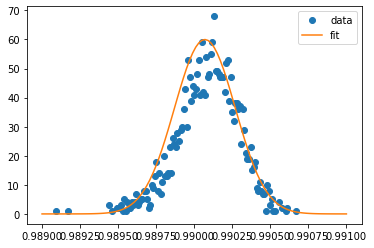

In [192]:
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(50,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()